In [5]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [16]:
TPATH = '/home/arnavw/Code/ml/GAJSHIELD_KJSCE/model/data/image_data/malware_dataset/train'
VPATH = '/home/arnavw/Code/ml/GAJSHIELD_KJSCE/model/data/image_data/malware_dataset/val'

In [17]:
# Define transformations for grayscale images
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize to fixed size
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

# Use ImageFolder to load the dataset
train_dataset = datasets.ImageFolder(root=TPATH, transform=transform)
val_dataset = datasets.ImageFolder(root=VPATH, transform=transform)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

In [8]:
class FeatureExtractorCNN(nn.Module):
    def __init__(self):
        super(FeatureExtractorCNN, self).__init__()
        self.model = nn.Sequential(
            # Block 1
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (Batch, 64, 32, 32)
            
            # Block 2
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (Batch, 64, 16, 16)
            
            # Block 3
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: (Batch, 32, 8, 8)
            
            # Flatten
            nn.Flatten(),
            
            # Fully Connected Layer
            nn.Linear(32 * 8 * 8, 256),  # Adjust based on input size
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),  # Final feature vector size
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.model(x)


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
feature_extractor = FeatureExtractorCNN().to(device)
summary(feature_extractor, (1, 64, 64))  # Input shape is (batch_size, channels, height * width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]             640
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              GELU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,928
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              GELU-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
         MaxPool2d-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]          18,464
      BatchNorm2d-11           [-1, 32, 16, 16]              64
             GELU-12           [-1, 32, 16, 16]               0
          Dropout-13           [-1, 32, 16, 16]               0
        MaxPool2d-14             [-1, 3

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(feature_extractor.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)  # Reduce LR by 10x every 5 epochs

# Training loop
def train_model(model, dataloader, criterion, optimizer, scheduler, num_epochs=25):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item()
            total += labels.size(0)
            correct += (preds == labels).sum().item()
        
        # Update learning rate
        scheduler.step()
        
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Train the CNN
train_model(feature_extractor, train_loader, criterion, optimizer, scheduler, num_epochs=25)

Epoch [1/25], Loss: 1.5694, Accuracy: 0.6549
Epoch [2/25], Loss: 0.6152, Accuracy: 0.8489
Epoch [3/25], Loss: 0.4659, Accuracy: 0.8793
Epoch [4/25], Loss: 0.3460, Accuracy: 0.9068
Epoch [5/25], Loss: 0.2859, Accuracy: 0.9197
Epoch [6/25], Loss: 0.2038, Accuracy: 0.9417
Epoch [7/25], Loss: 0.1698, Accuracy: 0.9503
Epoch [8/25], Loss: 0.1611, Accuracy: 0.9530
Epoch [9/25], Loss: 0.1452, Accuracy: 0.9578
Epoch [10/25], Loss: 0.1426, Accuracy: 0.9582
Epoch [11/25], Loss: 0.1255, Accuracy: 0.9641
Epoch [12/25], Loss: 0.1256, Accuracy: 0.9634
Epoch [13/25], Loss: 0.1281, Accuracy: 0.9651
Epoch [14/25], Loss: 0.1289, Accuracy: 0.9627
Epoch [15/25], Loss: 0.1246, Accuracy: 0.9641
Epoch [16/25], Loss: 0.1234, Accuracy: 0.9662
Epoch [17/25], Loss: 0.1180, Accuracy: 0.9660
Epoch [18/25], Loss: 0.1215, Accuracy: 0.9660
Epoch [19/25], Loss: 0.1209, Accuracy: 0.9670
Epoch [20/25], Loss: 0.1184, Accuracy: 0.9672
Epoch [21/25], Loss: 0.1152, Accuracy: 0.9665
Epoch [22/25], Loss: 0.1208, Accuracy: 0.96

In [19]:
for param in feature_extractor.parameters():
    param.requires_grad = False

In [20]:
import numpy as np

In [21]:
torch.save(feature_extractor.state_dict(), 'feature_extractor_test.pth')
# Load the model

In [15]:
feature_extractor = feature_extractor.load('feature_extractor.pth')
# model_load.to(device)


AttributeError: 'FeatureExtractorCNN' object has no attribute 'load'

In [22]:
def extract_features(dataloader, model):
    model.eval()  # Set model to evaluation mode
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in dataloader:
            images, targets = images.to(device), targets.to(device)
            outputs = model(images)
            features.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())
    return np.vstack(features), np.hstack(labels)

# Extract features from the dataset
val_features, val_labels = extract_features(val_loader, feature_extractor)

In [23]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [24]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(val_features, val_labels, test_size=0.2, random_state=42)

# Train XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Evaluate the model
val_predictions = xgb_model.predict(X_val)
accuracy = np.mean(val_predictions == y_val)
print(f"Validation Accuracy: {accuracy:.4f}")

/home/arnavw/Code/ml/GAJSHIELD_KJSCE/model/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [08:51:56] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy: 0.9330


In [29]:
xgb_model.save_model("feature_extractor_test.json")

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

In [40]:
def evaluate_xgboost_on_test_data(test_val, val_pred):
    # Extract features from test dataset


    # Calculate metrics
    # accuracy = accuracy_score(test_val, val_pred)
    # precision = precision_score(test_val, val_pred)
    # recall = recall_score(test_val, val_pred)
    # f1 = f1_score(test_val, val_pred)
    report = classification_report(test_val, val_pred, target_names=["Benign", "Malware"])

    return report

In [43]:
from sklearn.metrics import accuracy_score

# accuracy_score = accuracy_score(y_val, val_predictions)
report = classification_report(y_val, val_predictions)

    # Display results in a tabular format
print("\n--- Classification Report ---")
print(report)


--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        29
           1       0.91      0.78      0.84        37
           2       0.96      0.93      0.95        29
           3       1.00      1.00      1.00         7
           4       0.97      0.97      0.97        34
           5       0.94      0.85      0.89        20
           6       0.81      0.90      0.85        29
           7       1.00      1.00      1.00        24
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00         8
          10       1.00      0.92      0.96        36
          11       0.92      0.92      0.92        25
          12       0.82      0.82      0.82        34
          13       1.00      1.00      1.00        14
          14       1.00      1.00      1.00        32
          15       1.00      1.00      1.00        31
          16       1.00      1.00      1.00       

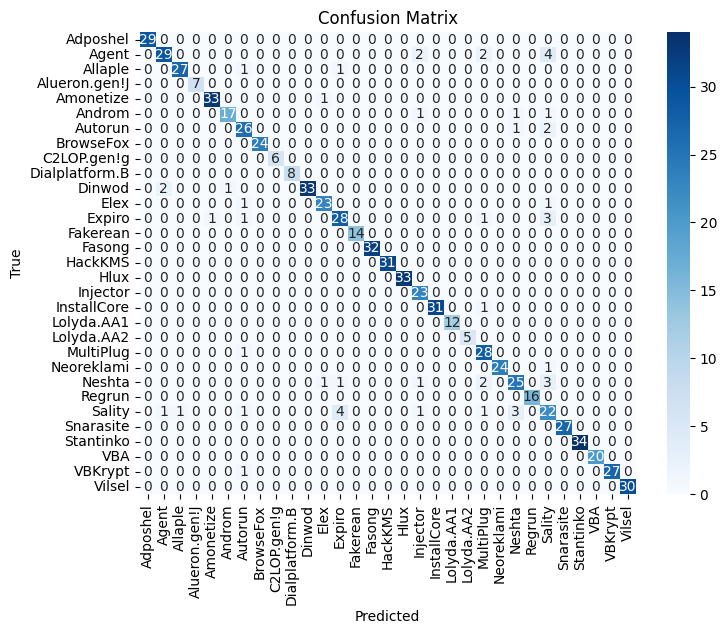

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_val, val_predictions)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

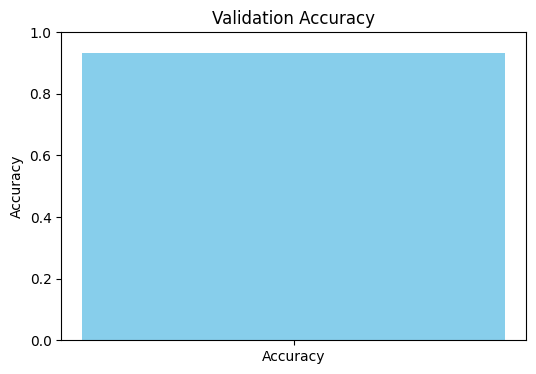

In [26]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_val, val_predictions)

# Plot accuracy
plt.figure(figsize=(6, 4))
plt.bar(['Accuracy'], [accuracy], color='skyblue')
plt.ylim(0, 1)
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.show()

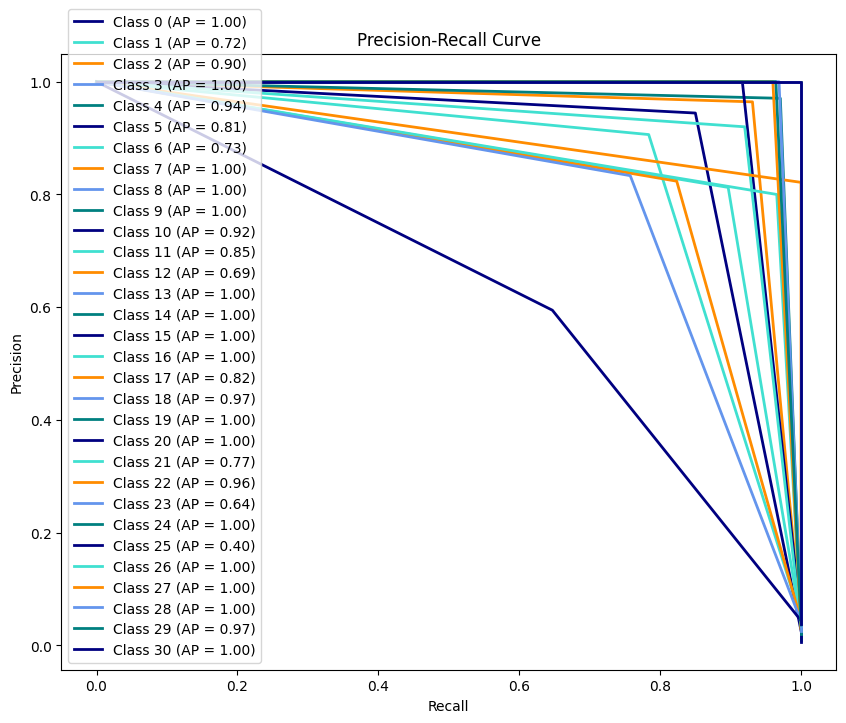

In [27]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels for multi-class classification
y_val_bin = label_binarize(y_val, classes=range(len(train_dataset.classes)))
val_pred_bin = label_binarize(val_predictions, classes=range(len(train_dataset.classes)))

# Compute precision-recall pairs for each class
precision = dict()
recall = dict()
average_precision = dict()
n_classes = len(train_dataset.classes)

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_val_bin[:, i], val_pred_bin[:, i])
    average_precision[i] = average_precision_score(y_val_bin[:, i], val_pred_bin[:, i])

# Plot precision-recall curve for each class
plt.figure(figsize=(10, 8))
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label=f'Class {i} (AP = {average_precision[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

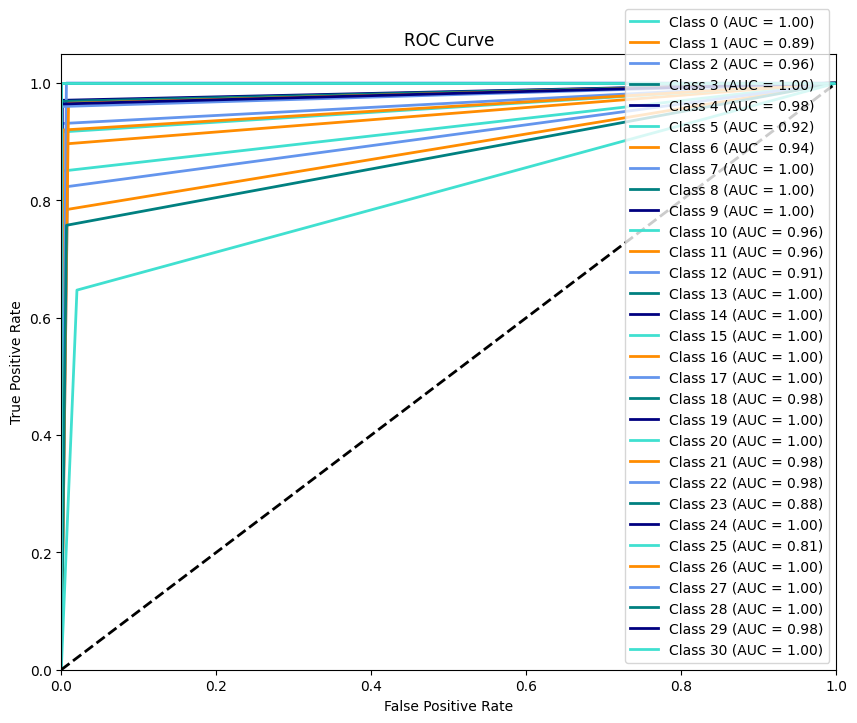

In [28]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], val_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [45]:
import math
from PIL import Image
import numpy as np

def exe_to_image(exe_path, output_path):
    # Read the executable file in binary mode
    with open(exe_path, 'rb') as f:
        byte_data = f.read()
    
    # Calculate dimensions for a square-ish image
    data_len = len(byte_data)
    width = math.ceil(math.sqrt(data_len))
    height = width
    
    # Create a numpy array and pad with zeros if needed
    img_array = np.zeros((height, width), dtype=np.uint8)
    np_data = np.frombuffer(byte_data, dtype=np.uint8)
    img_array.flat[:len(np_data)] = np_data
    
    # Create and save the image
    img = Image.fromarray(img_array, mode='L')
    img.save(output_path)
    print(f"Image saved to {output_path} (Dimensions: {width}x{height})")

# Usage example
exe_to_image('./data/6.exe', 'exam6.png')

Image saved to exam6.png (Dimensions: 2133x2133)


In [3]:
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')  # Ensure RGB format
    image = transform(image)  # Apply transformations
    image = image.unsqueeze(0)  # Add batch dimension (Batch, Channels, Height, Width)
    return image

# Example usage
image_path = 'test_bytecode_image.png'
input_image = preprocess_image(image_path)

NameError: name 'transform' is not defined

In [49]:
def extract_features_single_image(model, image):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        image = image.to(device)  # Move image to the same device as the model
        features = model(image)  # Extract features
        features = features.cpu().numpy()  # Move features back to CPU for XGBoost
    return features

# Extract features
features = extract_features_single_image(feature_extractor, input_image)

In [ ]:
# Predict using the trained XGBoost model
def predict_with_xgboost(xgb_model, features):
    prediction = xgb_model.predict(features)  # Get the predicted class
    return prediction

# Make prediction
predicted_class = predict_with_xgboost(xgb_model, features)
print(f"Predicted Class: {predicted_class[0]}")

AttributeError: 'XGBClassifier' object has no attribute 'predictProba'